# 2A.ml : Arbres de décision / Random Forest - correction

Méthodes ensemblistes, features importance, correction.

In [ ]:
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

### Données

On reprend le code qui permet d'obtenir les données (il faut l'exécuter avant chaque partie).

In [ ]:
import os
if not os.path.exists("salaries2010.db3"):
    import pyensae
    db3 = pyensae.download_data("salaries2010.zip")

import sqlite3, pandas
con = sqlite3.connect("salaries2010.db3")
df = pandas.io.sql.read_sql("select * from varmod", con)
con.close()

values = df[ df.VARIABLE == "TRNETTOT"].copy()

def process_intervalle(s):
    if "euros et plus" in s : 
        return float ( s.replace("euros et plus", "").replace(" ","") )
    spl = s.split("à")
    if len(spl) == 2 : 
        s1 = spl[0].replace("Moins de","").replace("euros","").replace(" ","")
        s2 = spl[1].replace("Moins de","").replace("euros","").replace(" ","")
        return (float(s1)+float(s2))/2
    else : 
        s = spl[0].replace("Moins de","").replace("euros","").replace(" ","")
        return float(s)/2

values["montant"] = values.apply(lambda r : process_intervalle(r ["MODLIBELLE"]), axis = 1)

con = sqlite3.connect("salaries2010.db3")
data = pandas.io.sql.read_sql("select TRNETTOT,AGE,SEXE,DEPT,DEPR,TYP_EMPLOI,PCS,CS,CONT_TRAV,CONV_COLL from salaries", con)
con.close()

salaires = data.merge ( values, left_on = "TRNETTOT", right_on="MODALITE" )
salaires.dropna(inplace=True)
salaires.head()

,TRNETTOT,AGE,SEXE,DEPT,DEPR,TYP_EMPLOI,PCS,CS,CONT_TRAV,CONV_COLL,VARIABLE,MODALITE,MODLIBELLE,montant
0,14,50,1,,972,O,628G,62,ZZZ,,TRNETTOT,14,18 000 à 19 999 euros,18999.5
1,14,41,1,75,75,O,354C,35,CDD,1734,TRNETTOT,14,18 000 à 19 999 euros,18999.5
2,14,29,1,75,75,O,373C,37,CDD,0014,TRNETTOT,14,18 000 à 19 999 euros,18999.5
3,14,30,1,75,75,O,651A,65,CDD,9999,TRNETTOT,14,18 000 à 19 999 euros,18999.5
4,14,55,1,78,92,O,623E,62,ZZZ,,TRNETTOT,14,18 000 à 19 999 euros,18999.5


In [ ]:
salaires.shape

(2191579, 15)

### Exercice 1 : Bases d'apprentissage, test, courbes

On ne considère qu'une partie de la base pour éviter de passer toute la séance à attendre les résultats :

In [ ]:
import random
salaires["rnd"] = salaires.apply (lambda r : random.randint(0,50),axis=1)
ech = salaires [ salaires.rnd == 0 ]
X,Y = ech[["AGE","SEXE","TYP_EMPLOI","CONT_TRAV", "CS"]], ech[["montant"]]
Xd = X.T.to_dict().values()
X.shape

(42990, 5)

On transforme les variables sous forme de chaînes de caractères en variables binaires :

In [ ]:
from sklearn.feature_extraction import DictVectorizer
prep = DictVectorizer()
Xt = prep.fit_transform(Xd).toarray()

On découpe la base en base d'apprentissage et test :

In [ ]:
from sklearn.model_selection import train_test_split
a_train, a_test, b_train, b_test = train_test_split(Xt, Y, test_size=0.33)

#### Expérience 1

On fait varier un paramètre et on observe l'erreur sur la base d'apprentissage et de test.

max_depth 1 erreur 11547.6208016 11741.4027609
max_depth 2 erreur 11543.467852 11742.3655268
max_depth 3 erreur 11537.9757537 11745.6860632
max_depth 4 erreur 11530.2292692 11753.4460197
max_depth 5 erreur 11520.7479109 11766.1464728
max_depth 6 erreur 11507.5683621 11776.6671374
max_depth 7 erreur 11493.9517345 11786.783246
max_depth 8 erreur 11478.6930351 11798.1549623
max_depth 9 erreur 11459.5224711 11819.6002706


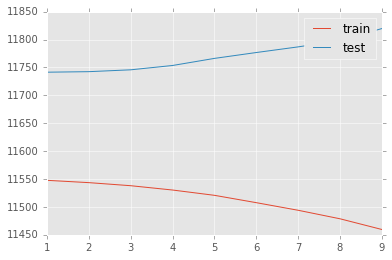

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

curves = []
for max_depth in range(1,10) :
    clf = DecisionTreeRegressor(min_samples_leaf=10, max_depth=max_depth)
    clf = clf.fit(a_train, b_train)
    erra = mean_squared_error( clf.predict(a_train), b_train)**0.5
    errb = mean_squared_error( clf.predict(a_test), b_test)**0.5
    print("max_depth",max_depth, "erreur",erra,errb)
    curves.append((max_depth, erra,errb, clf) )

plt.plot ( [c[0] for c in curves], [c[1] for c in curves], label="train")
plt.plot ( [c[0] for c in curves], [c[2] for c in curves], label="test")
plt.legend()

L'erreur sur la base de test baisse légèrement jusqu'à ce que l'arbre ait une profondeur de 3 ou 4. C'est la taille de l'arbre qu'il faudrait choisir et qu'on dessine en remplaçant les noms des variables ``X[i]`` par des noms plus intelligibles.

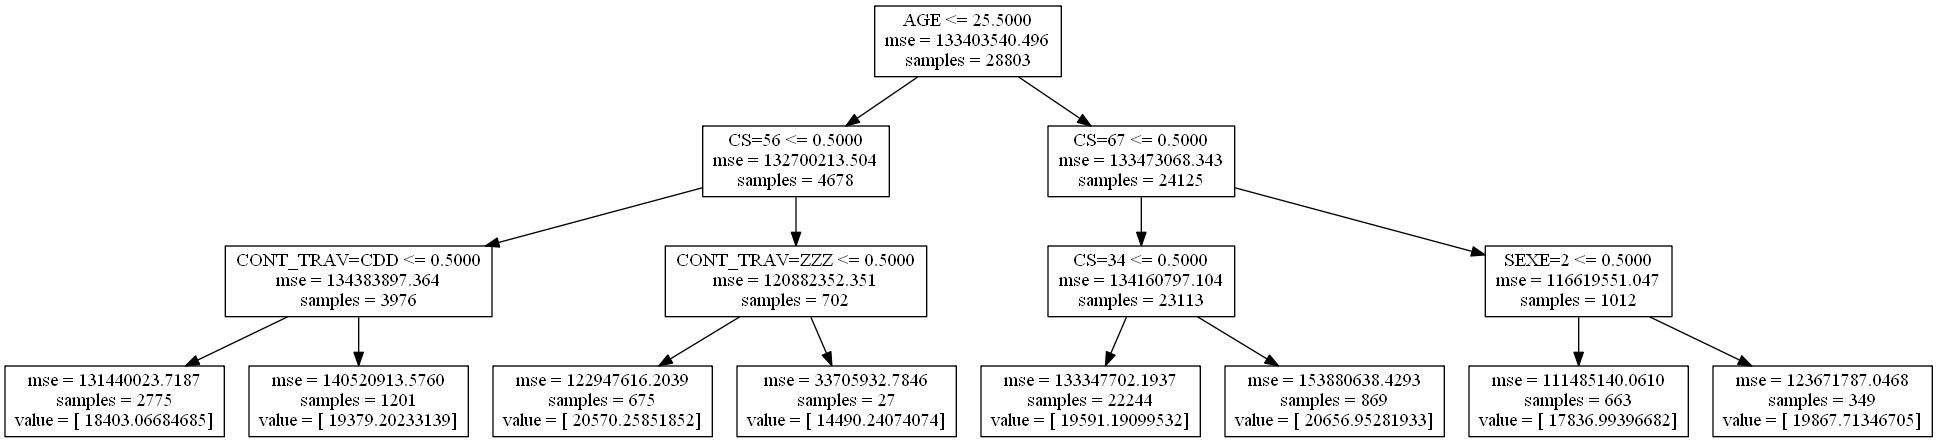

In [ ]:
clf = curves[2][-1]
from sklearn.tree import export_graphviz
export_graphviz(clf, out_file="arbrec.dot") 
# on remplace X[i] par les noms des variables
with open("arbrec.dot","r") as f: text = f.read()
for i in range(len(prep.feature_names_)):
    text=text.replace("X[{0}]".format(i), prep.feature_names_[i])
with open("arbrec.dot","w") as f: f.write(text)
    
cwd = os.getcwd()
os.system ("\"C:\\Program Files (x86)\\Graphviz2.34\\bin\\dot.exe\" -Tpng {0}\\arbrec.dot -o {0}\\arbrec.png".format(cwd))
from IPython.core.display import Image
Image("arbrec.png")

#### Expérience 2

On remplace l'arbre de décision par des random forest.

In [ ]:
import random
salaires["rnd"] = salaires.apply (lambda r : random.randint(0,50),axis=1)
ech = salaires [ salaires.rnd == 0 ]
X,Y = ech[["AGE","SEXE","TYP_EMPLOI","CONT_TRAV", "CS"]], ech[["montant"]]
Xd = X.T.to_dict().values()

from sklearn.feature_extraction import DictVectorizer
prep = DictVectorizer()
Xt = prep.fit_transform(Xd).toarray()

from sklearn.model_selection import train_test_split
a_train, a_test, b_train, b_test = train_test_split(Xt, Y, test_size=0.33)

n_estimators 1 erreur 11519.8470452 11518.4328039
n_estimators 2 erreur 11517.9895094 11518.2838727
n_estimators 3 erreur 11517.7578496 11522.9927008
n_estimators 4 erreur 11517.866163 11518.707252
n_estimators 5 erreur 11517.5754918 11519.0121763
n_estimators 6 erreur 11517.2713295 11519.3620283
n_estimators 7 erreur 11516.744769 11518.4505056
n_estimators 8 erreur 11517.0879998 11521.2402945
n_estimators 9 erreur 11517.0466461 11520.6562735


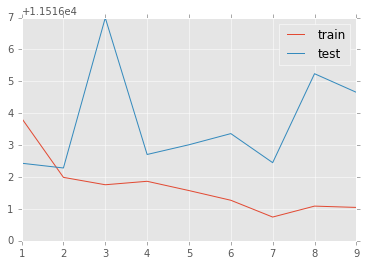

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import array

curves = []
for n_estimators in range(1,10) :
    clf = RandomForestRegressor(n_estimators=n_estimators,max_depth=1,min_samples_leaf=10)
    clf = clf.fit(a_train, b_train["montant"].ravel())
    erra = mean_squared_error( clf.predict(a_train), b_train)**0.5
    errb = mean_squared_error( clf.predict(a_test), b_test)**0.5
    print("n_estimators",n_estimators, "erreur",erra,errb)
    curves.append((n_estimators, erra,errb, clf) )

plt.plot ( [c[0] for c in curves], [c[1] for c in curves], label="train")
plt.plot ( [c[0] for c in curves], [c[2] for c in curves], label="test")
#plt.ylim( [11300,11600] )
plt.legend()

On obtient plus rapidement le même résultat qu'avec les arbres de décision.

### Exercice 2 : Courbes ROC

#### Première courbe

On enlève juste les valeurs imprévues.

In [ ]:
import random, numpy
tsalaires = salaires[ (salaires["SEXE"].notnull()) & ((salaires["SEXE"] == "1") | (salaires["SEXE"] == "2")) ].copy()
tsalaires["rnd"] = tsalaires.apply (lambda r : random.randint(0,50),axis=1)
ech = tsalaires [ tsalaires.rnd == 0 ].copy()

In [ ]:
X,Y = ech[["AGE","TYP_EMPLOI","CONT_TRAV", "CS", "montant"]], ech[["SEXE"]].copy()
Xd = X.T.to_dict().values()
Y["SEXE"] = Y.apply ( lambda r : int(r["SEXE"])-1, axis=1)

from sklearn.feature_extraction import DictVectorizer
prep = DictVectorizer()
Xt = prep.fit_transform(Xd).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
a_train, a_test, b_train, b_test = train_test_split(Xt, Y, test_size=0.33)

On apprend un classifieur (masculin ou féminin) :

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=10)
clf = clf.fit(a_train, b_train["SEXE"].ravel())

Et la courbe ROC :

Area under the ROC curve : 0.489902


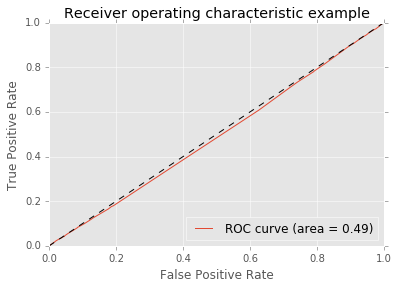

In [ ]:
from sklearn.metrics import roc_curve, auc

probas = clf.predict_proba(a_test)
# probas est une matrice de deux colonnes avec la proabilités d'appartenance à chaque classe

fpr, tpr, thresholds = roc_curve(b_test["SEXE"].ravel(), probas[:, 1])
roc_auc = auc(fpr, tpr)
print ("Area under the ROC curve : %f" % roc_auc)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

Une courbe comme celle-là veut dire que le classifieur ne fait pas beaucoup mieux que le hasard. On va tricher un peu et apprendre le modèle sur la base de test pour voir ce qu'on devrait voir si le modèle était un bon prédicteur :

Area under the ROC curve : 0.925091


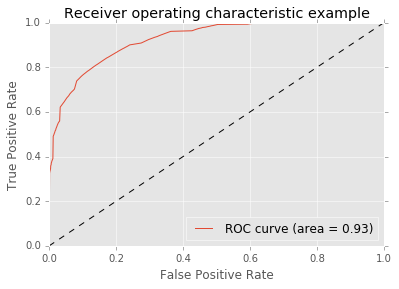

In [ ]:
from sklearn.ensemble import RandomForestClassifier
    
clf = RandomForestClassifier()
clf = clf.fit(a_test, b_test["SEXE"].ravel())

probas = clf.predict_proba(a_test)
# probas est une matrice de deux colonnes avec la proabilités d'appartenance à chaque classe

fpr, tpr, thresholds = roc_curve(b_test["SEXE"].ravel(), probas[:, 1])
roc_auc = auc(fpr, tpr)
print ("Area under the ROC curve : %f" % roc_auc)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

#### Un peu plus de features et...

Dans les exemples précédents, deux variables numériques (``AGE`` et ``montant``) ont été traitées comme catégorielles et il serait plus efficace de les traiter comme numériques (1 feature au lieu $n$ features avec $n$ = le nombre d'âges différents). Cela présente l'avantage de ne pas avoir que des [features sparses](http://en.wikipedia.org/wiki/Sparse_array).

In [ ]:
import random, numpy
tsalaires = salaires[ (salaires["SEXE"].notnull()) & ((salaires["SEXE"] == "1") | (salaires["SEXE"] == "2")) ].copy()
tsalaires["rnd"] = tsalaires.apply (lambda r : random.randint(0,50),axis=1)
ech = tsalaires [ tsalaires.rnd == 0 ].copy()
Xn,Xc,Y = ech[["AGE","montant"]], \
          ech[["TYP_EMPLOI","CONT_TRAV", "CS", "CONV_COLL", "DEPT", "DEPR", "PCS"]], \
          ech[["SEXE"]].copy()
Xd = Xc.T.to_dict().values()
Y["SEXE"] = Y.apply ( lambda r : int(r["SEXE"])-1, axis=1)

from sklearn.feature_extraction import DictVectorizer
prep = DictVectorizer()
Xt = prep.fit_transform(Xd).toarray()
Xt = numpy.hstack((Xn,Xt))

from sklearn.model_selection import train_test_split
a_train, a_test, b_train, b_test = train_test_split(Xt, Y, test_size=0.33)

On teste différents modèles et on vérifie que le fait de considérer les variables ``AGE`` et ``montant`` est plus efficace. Les deux dernières options proposent deux façons de réduire le nombre de varaibles en entrée avec une ACP et en utilisant un objet [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) qui permet de chaîner les opérations sur le même jeu de données. Ce dernière exemple explique l'intérêt d'avoir les mêmes méthodes pour chaque modèle.

In [ ]:
model = "GBC"
if model == "lda":
    from sklearn.lda import LDA
    clf = LDA(n_components=2)
    clf = clf.fit(a_train, (b_train["SEXE"]+1.0).ravel())
elif model == "tree":
    from sklearn.tree import DecisionTreeClassifier
    clf = DecisionTreeClassifier(max_depth=10)
    clf = clf.fit(a_train, b_train["SEXE"].ravel())
elif model == "forest":
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier()
    clf = clf.fit(a_train, b_train["SEXE"].ravel())    
elif model=="pipeline":
    from sklearn.pipeline import Pipeline
    from sklearn.svm import LinearSVC
    from sklearn.decomposition import PCA
    from sklearn.lda import LDA
    clf = Pipeline([
      ('feature_selection', PCA(n_components=10)),
      ('classification', LDA())
    ])
    clf = clf.fit(a_train, b_train["SEXE"].ravel()) 
elif model=="GBC":
    from sklearn.ensemble import GradientBoostingClassifier    
    clf = GradientBoostingClassifier(n_estimators=10)
    clf = clf.fit(a_train, b_train["SEXE"].ravel()) 
else:
    raise Exception("unknown model: " + model)

On trace la courbe ROC pour mesurer la performance du modèle.

Area under the ROC curve : 0.623861


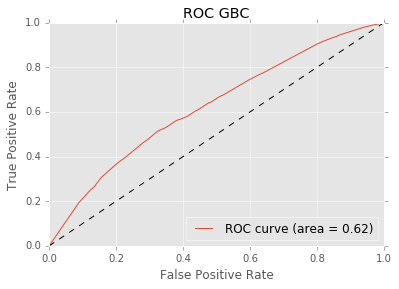

In [ ]:
from sklearn.metrics import roc_curve, auc
probas = clf.predict_proba(a_test)
fpr, tpr, thresholds = roc_curve(b_test["SEXE"].ravel(), probas[:, 1])
roc_auc = auc(fpr, tpr)
print ("Area under the ROC curve : %f" % roc_auc)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC ' + model)
plt.legend(loc="lower right")

Si le model choisi est un [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), on peut regarder l'importance des variables dans la construction du résultat. Le graphe suivant est inspiré de la page [Gradient Boosting regression](http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html) même si ce n'est pas une régression qui a été utilisée ici.

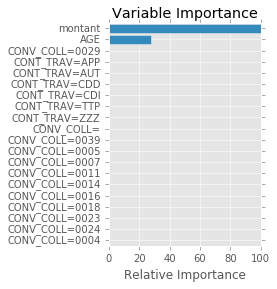

In [ ]:
if model == "GBC":
    import pandas
    import numpy as np
    feature_name = pandas.Series(["AGE","montant"] + prep.feature_names_)
    
    limit = 20
    feature_importance = clf.feature_importances_[:20]

    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, feature_name[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')